## Analysing CSI data for a reliable "Activity Indicator" metric

In [1]:
import sys

sys.path.insert(0, "..")

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from HAR.transformers import CSIMinMaxScaler
from HAR.io import load_dataset

sns.set_theme()

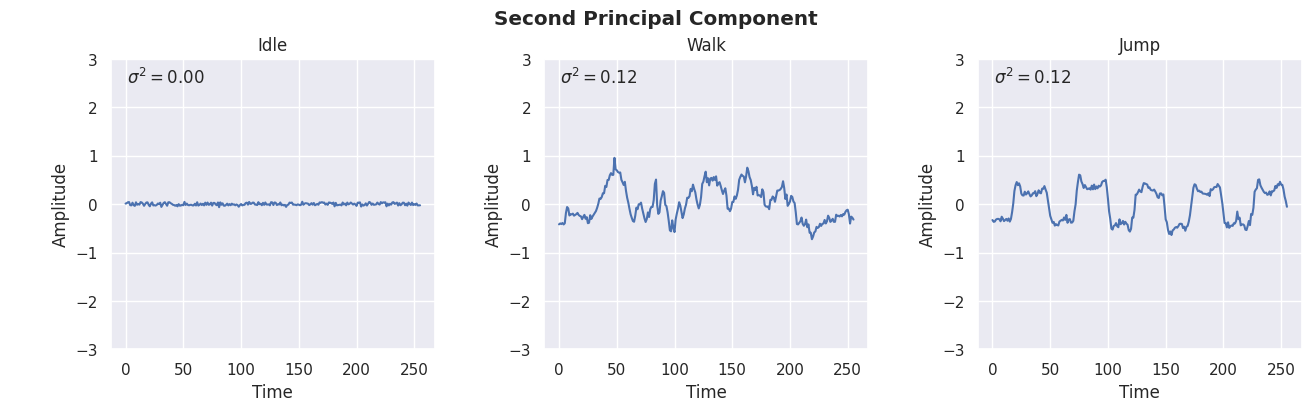

In [2]:
X, y, nsamples, classnames, dim = load_dataset("../dataset/rCSI-dall.mat")
X = X.reshape(X.shape[0], *dim)
X = CSIMinMaxScaler().fit_transform(X)

rng = np.random.default_rng(seed=8)

plt.figure(figsize=(13, 4), constrained_layout=True)
for i in range(len(classnames)):
    isample = nsamples[:i].sum() + rng.integers(0, nsamples[i])
    sample = X[isample, :, :]

    U, _, _ = np.linalg.svd(sample)
    s = np.dot(U[:, 1], sample)

    plt.subplot(1, 3, i + 1)
    plt.plot(s)
    plt.ylim([-3, 3])
    plt.title(classnames[i].title())
    plt.text(1, 2.5, rf"$\sigma^2 = ${np.var(s):0.2f}")
    plt.xlabel("Time")
    plt.ylabel("\n\nAmplitude")

plt.suptitle("Second Principal Component", fontweight="bold")
plt.show()

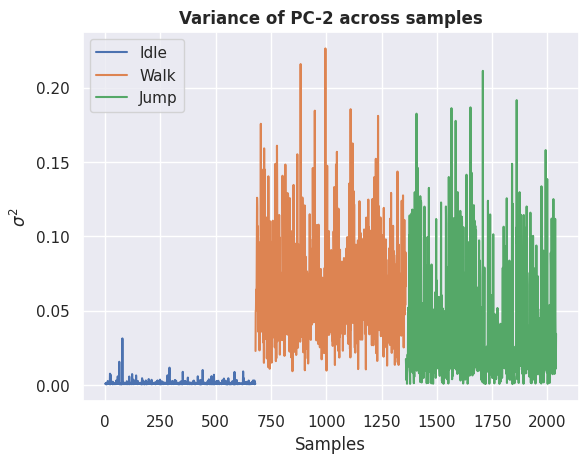

In [3]:
U, _, _ = np.linalg.svd(X)
pc2 = np.einsum("ijk,ij->ik", X, U[:, :, 1])
variances = np.var(pc2, axis=1)
for i in range(len(classnames)):
    xs = range(nsamples[:i].sum(), nsamples[: i + 1].sum())
    plt.plot(xs, variances[xs], label=classnames[i])
plt.xlabel("Samples")
plt.ylabel(r"$\sigma^2$")
plt.legend()
plt.title("Variance of PC-2 across samples", fontweight="bold")
plt.show()

In [4]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from scipy.optimize import fmin

y_actual = y.copy()
y_actual[y_actual != 0] = 1


def loss(th):
    y_pred = np.zeros_like(variances)
    y_pred[variances > th] = 1
    return 1 - accuracy_score(y_actual, y_pred)


th_opt = fmin(loss, np.array([0.1]))[0]

print("Optimal threshold:", th_opt)
y_pred = np.zeros_like(variances)
y_pred[variances > th_opt] = 1

print("\n> Accuracy score")
print(accuracy_score(y_actual, y_pred))
print("\n> Confusion matrix")
print(confusion_matrix(y_actual, y_pred))
print("\n> Classification Report :")
print(classification_report(y_actual, y_pred, target_names=["No Activity", "Activity"]))

Optimization terminated successfully.
         Current function value: 0.033824
         Iterations: 17
         Function evaluations: 35
Optimal threshold: 0.003515625000000188

> Accuracy score
0.9661764705882353

> Confusion matrix
[[ 651   29]
 [  40 1320]]

> Classification Report :
              precision    recall  f1-score   support

 No Activity       0.94      0.96      0.95       680
    Activity       0.98      0.97      0.97      1360

    accuracy                           0.97      2040
   macro avg       0.96      0.96      0.96      2040
weighted avg       0.97      0.97      0.97      2040

